In [9]:
import pandas as pd
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import pandas as pd


# for plotting purposes and K-means
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# used for creating descriptions of they key word cluster
from transformers import pipeline

# For preprocessing and lemmitization of Abstracts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
import nltk
import re

nltk.download('punkt')

import spacy
nlp = spacy.load('en_core_web_lg')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JakeBeckman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [25]:
# Preprocessing function
def tokenize_and_lemmatize(df):
    """
    Processes a DataFrame by lemmatizing and tokenizing the 'Text' column 
    and returns the DataFrame with an updated column containing the processed text.
    
    :param df: DataFrame with a 'Text' column.
    :return: DataFrame with a modified 'Text' column containing lemmatized and tokenized text.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    stop_words = nlp.Defaults.stop_words  # Default stop words from Spacy

    # Function to preprocess, tokenize, and lemmatize text
    def preprocess(text):
        tokens = text.split()
        # Lemmatize tokens and filter out stopwords
        processed_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
        # Join tokens back into a single string
        return ' '.join(processed_tokens)

    # Apply the preprocessing and tokenization function to the 'Text' column
    df['Text'] = df['Text'].fillna('').apply(preprocess)

    return df

df = tokenize_and_lemmatize(df)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought vitality canned dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts.....
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","confection centuries. light, pillowy citrus ge..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price. wide assortment yummy...


In [33]:
test_size = 0.3

df = df[['Text', 'Score']].dropna()  

train_data, test_data = train_test_split(df, test_size=test_size, random_state=42, stratify=df['Score'])

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 397917
Testing set size: 170537


In [39]:
# Combine text for each cluster (Score)
def combine_text(dataframe, cluster_label):
    """
    Combine text for a specific cluster label into one string.
    """
    texts = dataframe[dataframe['Score'] == cluster_label]['Text']
    combined_text = " ".join(texts.dropna().tolist())
    return combined_text

# Combine abstracts for each score (cluster) in the training data
cluster_texts = {}
for score in train_data['Score'].unique():
    cluster_texts[score] = combine_text(train_data, score)

# Truncate each string to the first 50 characters
truncated_dict = {key: value[:100] + "..." for key, value in cluster_texts.items()}

# Display the truncated dictionary
print(truncated_dict)

{5: "went canada visit nephew's godparent kind fussy got there. godmother gave vegetable mum-mum loved it...", 3: "it's hard believe crystal light moctails mojito mix doesn't sodium, taste bit like margarita. (i've ...", 1: 'eat - glycerin it. good quality claim - good glycerin it. little bad ruin bag good.<br /><br />and b...', 2: "ok, tell truth, read mad max's review, discussion chemical product, wee bit scared stuff. thing nece...", 4: 'good stuff going active while. going running aerobic activity long stretch times, packet hour feet. ...'}


In [43]:
# Prepare lists of combined cluster texts and their corresponding scores
cluster_combined_texts = list(cluster_texts.values())
cluster_labels = list(cluster_texts.keys())

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')

# Fit and transform the combined cluster texts to create the TF-IDF matrix
cluster_tfidf_matrix = vectorizer.fit_transform(cluster_combined_texts)

In [47]:
# Transform all texts in the test data at once
test_tfidf_matrix = vectorizer.transform(test_data['Text'])  # Vectorize all test data texts at once

# Compute cosine similarity in bulk
similarity_matrix = cosine_similarity(test_tfidf_matrix, cluster_tfidf_matrix)  # Compute similarity for all rows at once

# Find the index of the highest similarity for each test text
most_similar_indices = similarity_matrix.argmax(axis=1)  # Get the index of the max similarity for each row

# Map indices to corresponding cluster labels
test_data['Predicted_Score'] = [cluster_labels[idx] for idx in most_similar_indices]

# Display the first two rows of the resulting DataFrame
test_data.head(2)


,Text,Score,Predicted_Score
446457,huge fan all-natural baked treats. tried count...,5,5
457568,"better ""regular"" pretzels. light crunchy butte...",5,3


In [57]:

correct_predictions = (test_data['Score'] == test_data['Predicted_Score']).sum()
incorrect_predictions = (test_data['Score'] != test_data['Predicted_Score']).sum()

# Calculate percentages
total_predictions = len(test_data)
correct_percentage = (correct_predictions / total_predictions) * 100
incorrect_percentage = (incorrect_predictions / total_predictions) * 100

# Create a clean summary using a DataFrame
summary_df = pd.DataFrame({
    'Category': ['Correct Predictions', 'Incorrect Predictions'],
    'Count': [correct_predictions, incorrect_predictions],
    'Percentage (%)': [correct_percentage, incorrect_percentage]
})

# Display the summary DataFrame
print(summary_df.to_string(index=False))


             Category  Count  Percentage (%)
  Correct Predictions  81464       47.769106
Incorrect Predictions  89073       52.230894


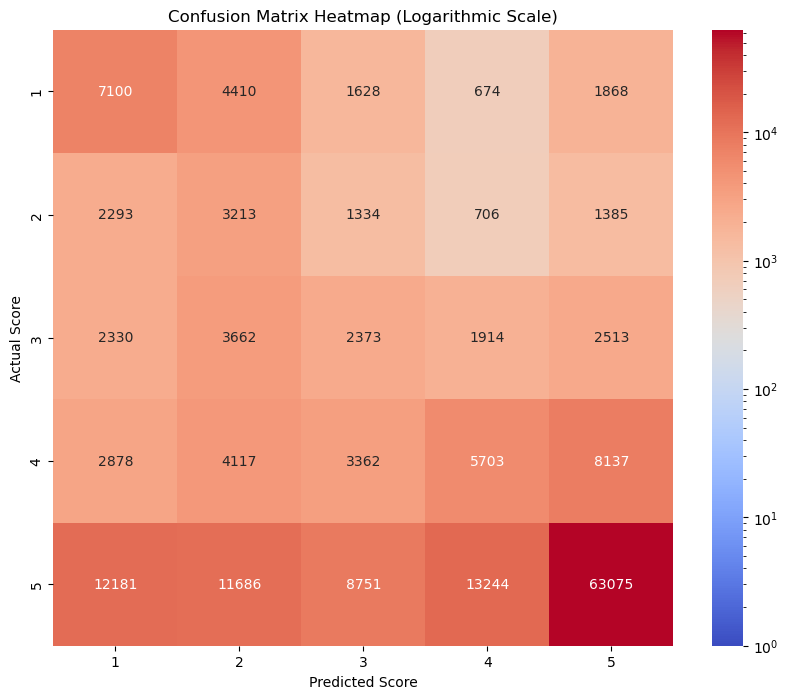

   Metric    Value
 Accuracy 0.477691
Precision 0.600587
 F1-Score 0.520154


In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

# Replace `test_data` with your actual DataFrame
# Ensure it has columns 'Score' (actual) and 'Predicted_Score' (predicted)
conf_matrix = confusion_matrix(test_data['Score'], test_data['Predicted_Score'])

# Plot a heatmap of the confusion matrix on a logarithmic scale
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=sorted(test_data['Score'].unique()),
            yticklabels=sorted(test_data['Score'].unique()),
            norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=conf_matrix.max()))
plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')
plt.title('Confusion Matrix Heatmap (Logarithmic Scale)')
plt.show()

# Calculate performance metrics
accuracy = accuracy_score(test_data['Score'], test_data['Predicted_Score'])
precision = precision_score(test_data['Score'], test_data['Predicted_Score'], average='weighted')
f1 = f1_score(test_data['Score'], test_data['Predicted_Score'], average='weighted')

# Create a DataFrame for metrics to display as a clean table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'F1-Score'],
    'Value': [accuracy, precision, f1]
})

# Display the metrics table
print(metrics_df.to_string(index=False))
